<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Other_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from datetime import datetime ; DATE_FORMAT,TIME_FORMAT='%m/%d/%Y','%H:%M:%S' ; DATETIME_FORMAT=DATE_FORMAT+" "+TIME_FORMAT
def nprint(*args,**kwargs): print(datetime.now().strftime(TIME_FORMAT),*args,**kwargs)
nprint("Installing yfinance and arch and other stuff...")
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning) # I don't care
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# import arch classes
from arch.univariate import ConstantMean,ARX,GeneralizedError,Normal,GARCH
from arch.typing import Float64Array

# change the constraints for GeneralizedError
class GeneralizedError2(GeneralizedError):
    """Version of the GED with bounds on fit adjusted to include all feasible distributions (GED is valid for all positive nu values)."""
    def bounds(self,*args)->list[tuple[float,float]]:
        """Revised bounds."""
        return [(0e0,1e2)]

    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        return np.array([[1], [-1]]), np.array([self.bounds()[0][0],-self.bounds()[0][1]])

# change the constraints for GARCH
class GARCH2(GARCH):
    """Version of GARCH with constraints modified to be more relaxed, leads to models that don't bind on constraints."""
    def bounds(self,resids:Float64Array)->list[tuple[float,float]]:
        """Modify bounds to be more relaxed."""
        v=float(np.mean(abs(resids)**self.power))
        bounds=[(1e-8*v,ten*v)]
        bounds.extend([(-one,two)]*(self.p+self.o+self.q))
        return bounds

    def constraints(self,*args)->tuple[Float64Array,Float64Array]:
        """Modify constraints to permit negative values for A and D etc."""
        a,b=super(GARCH2,self).constraints()
        b[1:(self.p+self.o+1)]=-one
        return a,b

nprint("Done.")

14:05:10 Installing yfinance and arch and other stuff...
14:05:35 Done.


In [10]:
# get the daily returns of the various market indices
universe=pd.DataFrame({
    "Ticker": ['^GSPC','^HSI','^FTSE','^N225','^FCHI','^GDAXI','^SSMI','^IBEX','^BVSP','^BFX','^AXJO','^STI','^KS11','^GSPTSE','399001.SZ','^TWII'],
    "Name":   ['S&P 500 Index','Hang Seng Index','FTSE-100 Index','Nikkei 225 Index','CAC 40 Index','DAX Index', 'Swiss Markets Index','IBEX 35 Index','Bovespa Index','BEL 20 Index',
               'S&P/ASX 200 Index','STI Index','KOSPI Composite Index','S&P/TSX Composite index','Shenzhen Index','TSEC Weighted Index'],
    "Country":["United States","Hong Kong","United Kingdom","Japan","France","Germany","Switzerland","Spain","Brazil","Belgium","Australia","Singapore","Korea",
               "Canada","China","Taiwan"],
    "Region": ["AMER","APAC","EMEA","APAC","EMEA","EMEA","EMEA","EMEA","LATAM","EMEA","APAC","APAC","APAC","AMER","APAC","APAC"],
    "Start":  ['1928-01-01','1987-01-01','1984-01-01','1965-01-01','1990-01-01','1987-01-01','1990-01-01','1993-01-01',"1993-01-01","1991-04-08",'1992-11-21','1998-01-01',
               '1997-01-01',"1984-12-01","1997-09-01",'1997-08-01'],
    "Zone":  ['US/Eastern','Asia/Hong_Kong','Europe/London','Asia/Tokyo','Europe/Paris','Europe/Berlin','Europe/Zurich','Europe/Madrid','America/Sao_Paulo','Europe/Brussels','Australia/Sydney','Asia/Singapore',
              'Asia/Seoul','America/Toronto','Asia/Shanghai','Asia/Shanghai'],
    "Open":  ['09:30','09:30','08:00','09:00','09:00','09:00','09:00','09:00','10:00','09:00','10:00','09:00','09:00','09:30','09:30','09:30'],
    "Close": ['16:00','16:00','16:30','15:00','17:30','17:30','17:30','17:30','17:55','17:30','16:00','17:00','15:30','16:00','15:00','13:00'],
    "ISO3":  ['USA','HKG','GBR','JPY','FRA','DEU','CHE','ESP','BRA','BEL','AUS','SPG','KOR','CAN','CHN','TWN'],
}).set_index("Ticker").sort_values(["Region","Start"])

for t in 'Open','Close':
    universe[t]=universe[t].apply(pd.Timestamp)

    for i in universe.index:
       universe.loc[i,t]=universe.loc[i,t].tz_localize(universe.loc[i,'Zone'])

data=pd.DataFrame()

for ticker in universe.index[:]:
    nprint(universe.loc[ticker,"Name"],universe.loc[ticker,"Country"])
    df=download(ticker,universe.loc[ticker,"Start"]).dropna()
    df['Daily Return']=df['Adj Close'].pct_change()*hundred
    df['Intraday Return']=df['Close']/df['Open']*hundred-hundred
    df['Overnight Return']=(hundred+df["Daily Return"])/(hundred+df["Intraday Return"])*hundred-hundred
    df.index=pd.DatetimeIndex(df.index).to_period('B')
    df.dropna(inplace=True)
    df.loc[df["Volume"]==0,"Volume"]=np.nan
    universe.loc[ticker,"Start"]=df.index[0]
    universe.loc[ticker,"End"]=df.index[-1]
    universe.loc[ticker,"Sample"]=df["Daily Return"].count()

    for column in df:
        data[(ticker,column)]=df[column]

    data=data.copy()

data.columns=pd.MultiIndex.from_tuples(tuple(data.columns))
universe.columns=pd.MultiIndex.from_tuples(map(lambda x:('Metadata',x),universe.columns))
display(universe)

14:05:57 S&P 500 Index United States
[*********************100%%**********************]  1 of 1 completed
14:05:59 S&P/TSX Composite index Canada
[*********************100%%**********************]  1 of 1 completed
14:06:00 Nikkei 225 Index Japan
[*********************100%%**********************]  1 of 1 completed
14:06:00 Hang Seng Index Hong Kong
[*********************100%%**********************]  1 of 1 completed
14:06:01 S&P/ASX 200 Index Australia
[*********************100%%**********************]  1 of 1 completed
14:06:02 KOSPI Composite Index Korea
[*********************100%%**********************]  1 of 1 completed
14:06:02 TSEC Weighted Index Taiwan
[*********************100%%**********************]  1 of 1 completed
14:06:03 Shenzhen Index China
[*********************100%%**********************]  1 of 1 completed
14:06:03 STI Index Singapore
[*********************100%%**********************]  1 of 1 completed
14:06:04 FTSE-100 Index United Kingdom
[*********************100%%

Metadata                                     \
                              Name         Country Region       Start   
Ticker                                                                  
^GSPC                S&P 500 Index   United States   AMER  1928-01-04   
^GSPTSE    S&P/TSX Composite index          Canada   AMER  1984-12-04   
^N225             Nikkei 225 Index           Japan   APAC  1965-01-06   
^HSI               Hang Seng Index       Hong Kong   APAC  1987-01-05   
^AXJO            S&P/ASX 200 Index       Australia   APAC  1992-11-24   
^KS11        KOSPI Composite Index           Korea   APAC  1997-01-06   
^TWII          TSEC Weighted Index          Taiwan   APAC  1997-08-04   
399001.SZ           Shenzhen Index           China   APAC  1997-09-02   
^STI                     STI Index       Singapore   APAC  1998-01-05   
^FTSE               FTSE-100 Index  United Kingdom   EMEA  1984-01-04   
^GDAXI                   DAX Index         Germany   EMEA  1988-01-04   
^FCHI                 CAC 40 Index          France   EMEA  1990-03-02   
^SSMI          Swiss Markets Index     Switzerland   EMEA  1990-11-12   
^BFX                  BEL 20 Index         Belgium   EMEA  1991-04-10   
^IBEX                IBEX 35 Index           Spain   EMEA  1993-07-13   
^BVSP                Bovespa Index          Brazil  LATAM  1993-04-28   

                                                         \
                        Zone                       Open   
Ticker                                                    
^GSPC             US/Eastern  2023-12-15 09:30:00-05:00   
^GSPTSE      America/Toronto  2023-12-15 09:30:00-05:00   
^N225             Asia/Tokyo  2023-12-15 09:00:00+09:00   
^HSI          Asia/Hong_Kong  2023-12-15 09:30:00+08:00   
^AXJO       Australia/Sydney  2023-12-15 10:00:00+11:00   
^KS11             Asia/Seoul  2023-12-15 09:00:00+09:00   
^TWII          Asia/Shanghai  2023-12-15 09:30:00+08:00   
399001.SZ      Asia/Shanghai  2023-12-15 09:30:00+08:00   
^STI          Asia/Singapore  2023-12-15 09:00:00+08:00   
^FTSE          Europe/London  2023-12-15 08:00:00+00:00   
^GDAXI         Europe/Berlin  2023-12-15 09:00:00+01:00   
^FCHI           Europe/Paris  2023-12-15 09:00:00+01:00   
^SSMI          Europe/Zurich  2023-12-15 09:00:00+01:00   
^BFX         Europe/Brussels  2023-12-15 09:00:00+01:00   
^IBEX          Europe/Madrid  2023-12-15 09:00:00+01:00   
^BVSP      America/Sao_Paulo  2023-12-15 10:00:00-03:00   

                                                                
                               Close ISO3         End   Sample  
Ticker                                                          
^GSPC      2023-12-15 16:00:00-05:00  USA  2023-12-14  24103.0  
^GSPTSE    2023-12-15 16:00:00-05:00  CAN  2023-12-14   9812.0  
^N225      2023-12-15 15:00:00+09:00  JPY  2023-12-15  14497.0  
^HSI       2023-12-15 16:00:00+08:00  HKG  2023-12-15   9124.0  
^AXJO      2023-12-15 16:00:00+11:00  AUS  2023-12-15   7853.0  
^KS11      2023-12-15 15:30:00+09:00  KOR  2023-12-15   6646.0  
^TWII      2023-12-15 13:00:00+08:00  TWN  2023-12-15   6470.0  
399001.SZ  2023-12-15 15:00:00+08:00  CHN  2023-12-15   6371.0  
^STI       2023-12-15 17:00:00+08:00  SPG  2023-12-15   6495.0  
^FTSE      2023-12-15 16:30:00+00:00  GBR  2023-12-15  10093.0  
^GDAXI     2023-12-15 17:30:00+01:00  DEU  2023-12-15   9093.0  
^FCHI      2023-12-15 17:30:00+01:00  FRA  2023-12-15   8581.0  
^SSMI      2023-12-15 17:30:00+01:00  CHE  2023-12-15   8317.0  
^BFX       2023-12-15 17:30:00+01:00  BEL  2023-12-15   8296.0  
^IBEX      2023-12-15 17:30:00+01:00  ESP  2023-12-15   7708.0  
^BVSP      2023-12-15 17:55:00-03:00  BRA  2023-12-15   7584.0

'S&P/ASX 200, Nikkei 225, KOSPI Composite, STI, Hang Seng, TSEC Weighted, Shenzhen, FTSE-100, DAX, CAC 40, Swiss Markets, BEL 20, IBEX 35, Bovespa, S&P 500, S&P/TSX Composite index'

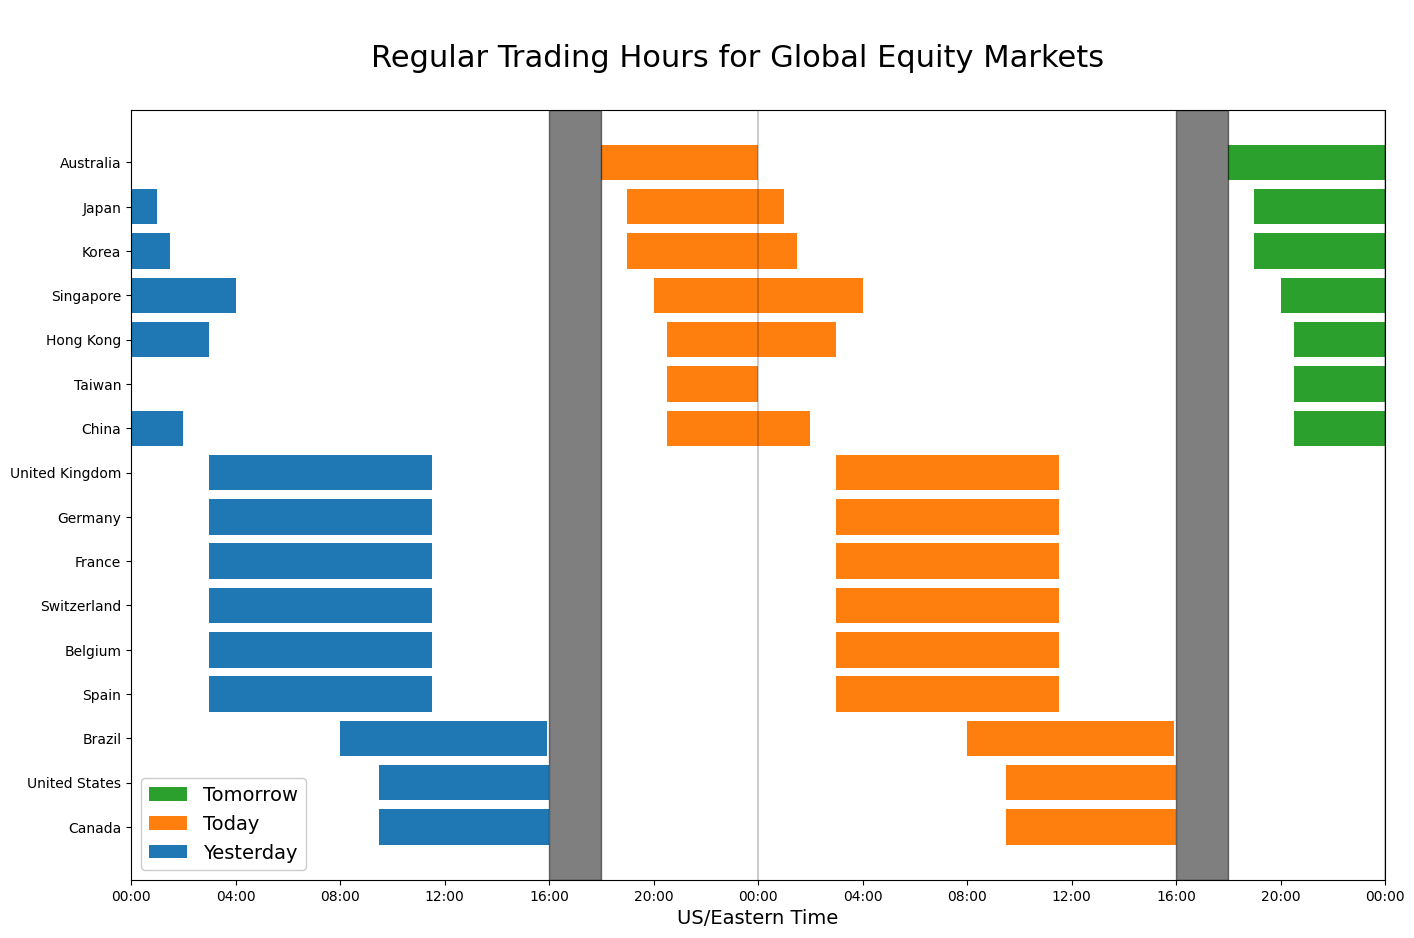

In [11]:
from matplotlib.dates import DateFormatter

viewpoint,vpoffset=universe.loc['^GSPC',("Metadata","Zone")],universe.loc['^GSPC',("Metadata","Open")].utcoffset()
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
design=universe[[('Metadata','Country'),('Metadata','Open'),('Metadata','Close')]].copy()
design.columns=pd.MultiIndex.from_tuples([('Country',""),('Local','Open'),('Local','Close')])

for c in 'Open','Close':
    design[('New York',c)]=design[('Local',c)].apply(lambda x:x.tz_convert(viewpoint))

design.sort_values(('New York','Open'),inplace=True)
day_start,day_end=pd.Timestamp('00:00').tz_localize(viewpoint)-pd.Timedelta("1 day 5 hour"),pd.Timestamp('00:00').tz_localize(viewpoint)+pd.Timedelta("19 hour 1 sec")

for offset in 1,0,-1:
    plot.barh(design["Country"],design[('New York','Close')]+pd.Timedelta("%d day" % offset)+vpoffset,color="C%d" % (offset+1),label=['Yesterday','Today','Tomorrow'][offset+1])
    plot.barh(design["Country"],design[('New York','Open')]+pd.Timedelta("%d day" % offset)+vpoffset,color="white")
    plot.axvline(pd.Timestamp("00:00")+pd.Timedelta("%d day" % offset),color='black',alpha=0.2)

plot.set_xlim(day_start,day_end)
plot.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plot.xaxis.set_ticks(np.arange(*plot.get_xlim(),4e0/24e0))
plot.invert_yaxis()
plot.set_xlabel(viewpoint+" Time",fontsize=14)
plot.legend(fontsize=14,loc='lower left',framealpha=1)

for offset in 0,1:
    plot.axvspan(
        design.loc['^GSPC',('Local','Close')]+pd.Timedelta("%d day"% (offset-1))+vpoffset,
        design.loc['^AXJO',('Local','Open')]+pd.Timedelta("%d day" % offset)+vpoffset,
        color='black',
        alpha=0.5
      )

title="Regular Trading Hours for Global Equity Markets"
figure.suptitle("\n"+title,fontsize=22)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')
", ".join(universe.sort_values(("Metadata","Open"))[("Metadata","Name")].apply(lambda x:x.replace(" Index","")))

14:06:22 Computing variance ratios for daytime and nighttime returns for [2000,2023].


Variance                              Ratio                     \
              Daily  Intraday Overnight Intraday:Daily Overnight:Intraday   
Ticker                                                                      
^GSPC      1.303392  0.779096  0.294541      59.774485          37.805565   
^GSPTSE    0.884229  0.480494  0.287826      54.340400          59.902073   
^N225      1.529141  0.688370  0.559364      45.016799          81.259158   
^HSI       1.822597  0.968937  0.770691      53.162471          79.539806   
^AXJO      0.951443  0.868782  0.024953      91.312011           2.872150   
^KS11      1.177524  0.796617  0.420882      67.651892          52.833647   
^TWII      0.925419  0.552616  0.206612      59.715173          37.388043   
399001.SZ  1.654650  1.410543  0.282102      85.247237          19.999492   
^STI       0.634917  0.338404  0.222793      53.298895          65.836400   
^FTSE      0.913099  0.912041  0.000304      99.884169           0.033345   
^GDAXI     1.331134  0.786589  0.531825      59.091664          67.611555   
^FCHI      1.268005  0.763278  0.469413      60.195182          61.499559   
^SSMI      0.735704  0.537272  0.182590      73.028279          33.984656   
^BFX       1.100592  0.703169  0.389354      63.890121          55.371346   
^IBEX      1.364802  0.924346  0.415798      67.727493          44.982914   
^BVSP      2.225177  2.201738  0.011917      98.946658           0.541256   

           Levene Test                                   Index         
             Statistic        p Value                     Name Region  
Ticker                                                                 
^GSPC       190.116055   1.552513e-41            S&P 500 Index   AMER  
^GSPTSE      97.861388   1.327223e-22  S&P/TSX Composite index   AMER  
^N225         0.031390   8.593900e-01         Nikkei 225 Index   APAC  
^HSI         18.307571   1.960546e-05          Hang Seng Index   APAC  
^AXJO       605.442346  3.148522e-118        S&P/ASX 200 Index   APAC  
^KS11        38.912710   5.304341e-10    KOSPI Composite Index   APAC  
^TWII       158.801133   3.347283e-35      TSEC Weighted Index   APAC  
399001.SZ   407.878305   2.614544e-83           Shenzhen Index   APAC  
^STI         31.741561   1.987909e-08                STI Index   APAC  
^FTSE       892.886348  7.959686e-165           FTSE-100 Index   EMEA  
^GDAXI       40.069993   2.963620e-10                DAX Index   EMEA  
^FCHI        55.418984   1.392471e-13             CAC 40 Index   EMEA  
^SSMI       113.145157   8.458243e-26      Swiss Markets Index   EMEA  
^BFX         77.449184   2.706681e-18             BEL 20 Index   EMEA  
^IBEX       132.924502   6.734516e-30            IBEX 35 Index   EMEA  
^BVSP      1124.689777  2.512244e-199            Bovespa Index  LATAM

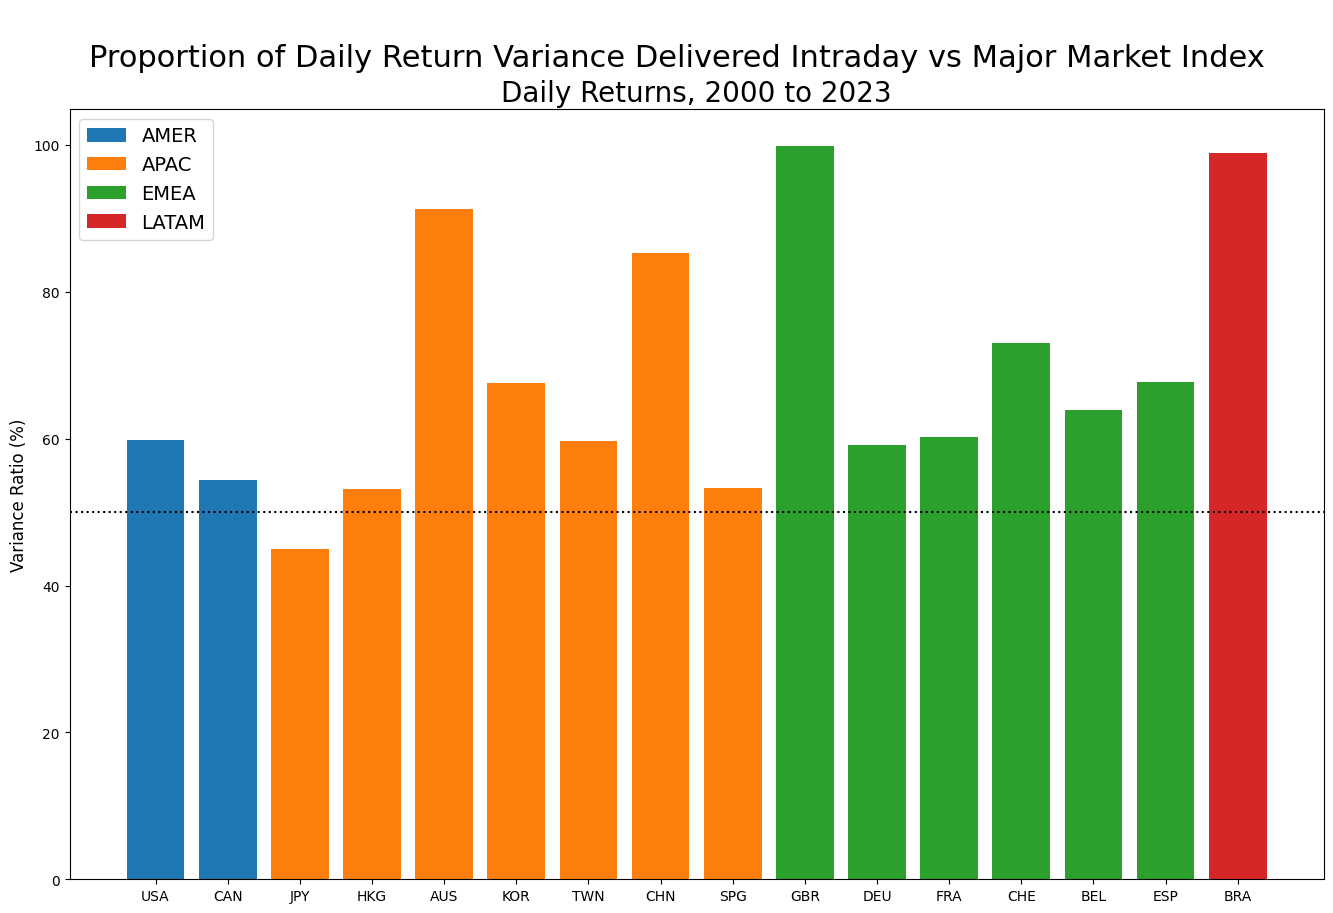

In [12]:
from scipy.stats import levene as variance_test
fyear,lyear=2000,datetime.now().year
nprint("Computing variance ratios for daytime and nighttime returns for [%d,%d]." % (fyear,lyear))

results=pd.DataFrame({"Ticker":[],("Variance","Daily"):[],("Variance","Intraday"):[],("Variance","Overnight"):[]}).set_index("Ticker")
results.columns=pd.MultiIndex.from_tuples(tuple(results.columns))

for ticker in universe.index:
    design=data[(data.index.year>=fyear) & (data.index.year<=lyear)].dropna().copy()

    for period in "Daily","Intraday","Overnight":
      results.loc[ticker,("Variance",period)]=design[(ticker,period+" Return")].var()

    tr=variance_test(design[(ticker,"Intraday Return")],design[(ticker,"Overnight Return")])
    results.loc[ticker,("Levene Test","Statistic")]=tr.statistic
    results.loc[ticker,("Levene Test","p Value")]=tr.pvalue

results[("Ratio","Intraday:Daily")]=results[("Variance","Intraday")]/results[("Variance","Daily")]*hundred
results[("Ratio","Overnight:Intraday")]=results[("Variance","Overnight")]/results[("Variance","Intraday")]*hundred
results=results[sorted(tuple(results.columns),key=lambda x:1 if x[0]=="Variance" else 2 if x[0]=="Ratio" else 3)].copy() # just changing column order
results[("Index","Name")]=universe[("Metadata","Name")]
results[("Index","Region")]=universe[("Metadata","Region")]
display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))

for region in "AMER","APAC","EMEA","LATAM":
    plot.bar(universe[universe[("Metadata","Region")]==region][("Metadata","ISO3")],results[universe[("Metadata","Region")]==region][("Ratio","Intraday:Daily")],label=region)

title="Proportion of Daily Return Variance Delivered Intraday vs Major Market Index"
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("Daily Returns, %d to %d" % (fyear,lyear),fontsize=20)
plot.legend(fontsize=14)
plot.set_ylabel("Variance Ratio (%)",fontsize=12)
plot.axhline(hundred/two,color='black',linestyle=':')
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

14:06:28 Daily Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.739789,0.122789,0.192682,0.178189,0.155647,0.124376,0.066534,0.224092,0.496008,0.529993,0.525825,0.471407,0.497830,0.494670,0.495289
^GSPTSE,0.739789,1.000000,0.226113,0.264042,0.272423,0.202951,0.181130,0.103455,0.295459,0.541861,0.505389,0.522048,0.467519,0.480723,0.497138,0.475959
^N225,0.122789,0.226113,1.000000,0.445831,0.522984,0.482061,0.448930,0.199664,0.482864,0.303415,0.270011,0.294284,0.294966,0.277822,0.266435,0.126268
^HSI,0.192682,0.264042,0.445831,1.000000,0.519289,0.493007,0.465130,0.353482,0.666577,0.355929,0.325008,0.341790,0.328245,0.332516,0.317443,0.197262
^AXJO,0.178189,0.272423,0.522984,0.519289,1.000000,0.444277,0.435022,0.212184,0.506957,0.343876,0.283803,0.315813,0.318306,0.322632,0.307707,0.174435
^KS11,0.155647,0.202951,0.482061,0.493007,0.444277,1.000000,0.482940,0.173668,0.492483,0.283885,0.262270,0.268872,0.245500,0.247683,0.240044,0.190821
^TWII,0.124376,0.181130,0.448930,0.465130,0.435022,0.482940,1.000000,0.209463,0.459727,0.233432,0.216492,0.235851,0.224104,0.222904,0.210756,0.145796
399001.SZ,0.066534,0.103455,0.199664,0.353482,0.212184,0.173668,0.209463,1.000000,0.221643,0.106933,0.092440,0.102810,0.084406,0.122540,0.084474,0.088655
^STI,0.224092,0.295459,0.482864,0.666577,0.506957,0.492483,0.459727,0.221643,1.000000,0.403132,0.348036,0.384835,0.358733,0.373792,0.358020,0.255562
^FTSE,0.496008,0.541861,0.303415,0.355929,0.343876,0.283885,0.233432,0.106933,0.403132,1.000000,0.758552,0.837196,0.763848,0.758466,0.765660,0.366781


14:06:36 Overnight Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.477751,-0.000475,0.085692,0.006440,0.034194,0.030160,0.041405,0.122270,0.003403,0.316572,0.306691,0.196257,0.286192,0.340120,0.007476
^GSPTSE,0.477751,1.000000,0.178621,0.238571,0.159272,0.150546,0.166028,0.086588,0.137119,0.178737,0.344558,0.451789,0.356725,0.399772,0.409449,0.098524
^N225,-0.000475,0.178621,1.000000,0.518690,0.252351,0.606979,0.538097,0.348539,0.509586,0.166364,0.265373,0.349653,0.384939,0.369024,0.360697,0.012950
^HSI,0.085692,0.238571,0.518690,1.000000,0.409406,0.634027,0.631851,0.428722,0.565232,0.190190,0.322969,0.471013,0.442251,0.482420,0.420264,0.080011
^AXJO,0.006440,0.159272,0.252351,0.409406,1.000000,0.319679,0.344577,0.181334,0.243137,0.345125,0.248509,0.288966,0.196728,0.292925,0.218385,0.154778
^KS11,0.034194,0.150546,0.606979,0.634027,0.319679,1.000000,0.651423,0.325798,0.564497,0.023096,0.276036,0.411316,0.408759,0.405276,0.366134,-0.011722
^TWII,0.030160,0.166028,0.538097,0.631851,0.344577,0.651423,1.000000,0.325513,0.512183,0.068510,0.263666,0.392146,0.375857,0.382376,0.325172,0.068629
399001.SZ,0.041405,0.086588,0.348539,0.428722,0.181334,0.325798,0.325513,1.000000,0.234523,0.002662,0.182392,0.188606,0.179293,0.234617,0.182069,0.004219
^STI,0.122270,0.137119,0.509586,0.565232,0.243137,0.564497,0.512183,0.234523,1.000000,0.112557,0.290759,0.412698,0.361248,0.371702,0.339205,0.034865
^FTSE,0.003403,0.178737,0.166364,0.190190,0.345125,0.023096,0.068510,0.002662,0.112557,1.000000,0.304979,0.290607,0.093005,0.238617,0.137921,0.079655


14:06:41 Intraday Return


,^GSPC,^GSPTSE,^N225,^HSI,^AXJO,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
^GSPC,1.000000,0.649742,0.119667,0.188332,0.146113,0.155483,0.133561,0.046703,0.203115,0.444292,0.505203,0.490582,0.439412,0.455776,0.450591,0.470373
^GSPTSE,0.649742,1.000000,0.022192,0.076067,0.106054,0.047166,0.050244,0.024547,0.077195,0.300519,0.301804,0.320848,0.288319,0.318305,0.284122,0.379173
^N225,0.119667,0.022192,1.000000,0.272167,0.344619,0.349026,0.242627,0.114126,0.357719,0.220551,0.067650,0.015999,0.070424,0.015116,0.065481,0.124637
^HSI,0.188332,0.076067,0.272167,1.000000,0.169363,0.328121,0.311270,0.302239,0.468547,0.224308,0.139618,0.078066,0.127408,0.089015,0.118291,0.168127
^AXJO,0.146113,0.106054,0.344619,0.169363,1.000000,0.209288,0.202892,0.117561,0.306958,0.334881,0.074351,0.042836,0.076772,0.065606,0.080669,0.157194
^KS11,0.155483,0.047166,0.349026,0.328121,0.209288,1.000000,0.357169,0.127116,0.331936,0.168339,0.091523,0.040662,0.042623,0.044943,0.063666,0.177227
^TWII,0.133561,0.050244,0.242627,0.311270,0.202892,0.357169,1.000000,0.152506,0.284458,0.123065,0.052683,0.030087,0.049412,0.033033,0.029818,0.156810
399001.SZ,0.046703,0.024547,0.114126,0.302239,0.117561,0.127116,0.152506,1.000000,0.140556,0.065186,-0.018649,-0.032124,-0.030493,0.003717,-0.024245,0.076532
^STI,0.203115,0.077195,0.357719,0.468547,0.306958,0.331936,0.284458,0.140556,1.000000,0.329220,0.189583,0.147928,0.143626,0.146459,0.182381,0.251108
^FTSE,0.444292,0.300519,0.220551,0.224308,0.334881,0.168339,0.123065,0.065186,0.329220,1.000000,0.658539,0.650972,0.593243,0.591189,0.613793,0.345527


,Correlation,N*,N-N*,N*/N
Period,,,,
Daily Return,33.038033,2.686500,13.313500,0.167906
Overnight Return,29.184209,2.975288,13.024712,0.185955
Intraday Return,17.980403,4.327763,11.672237,0.270485


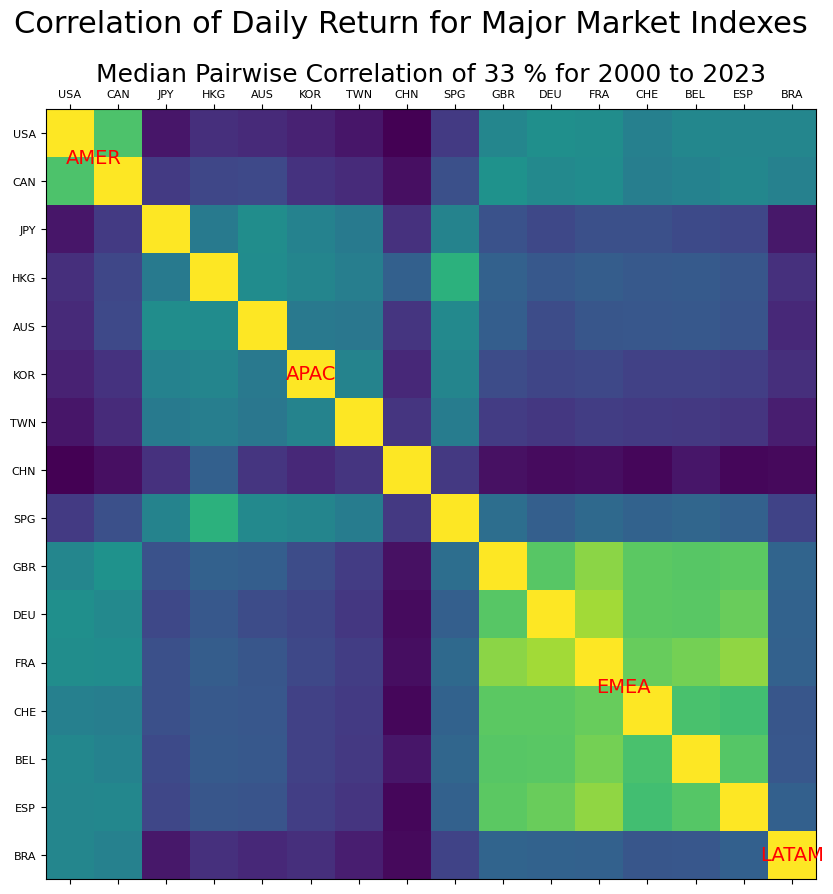

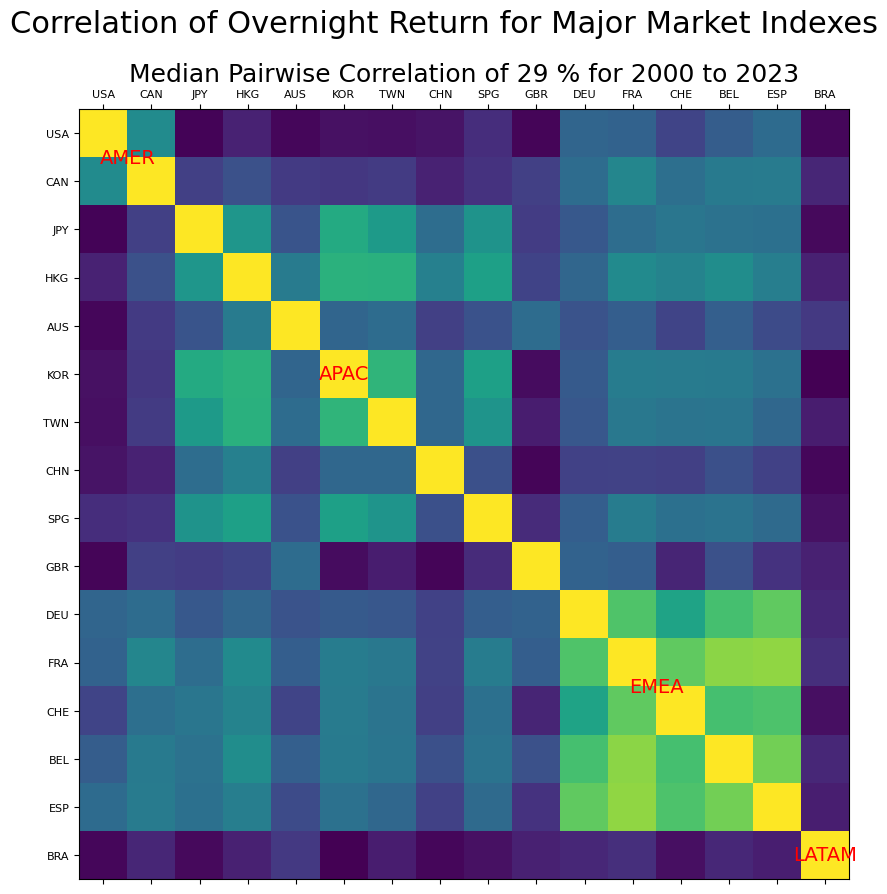

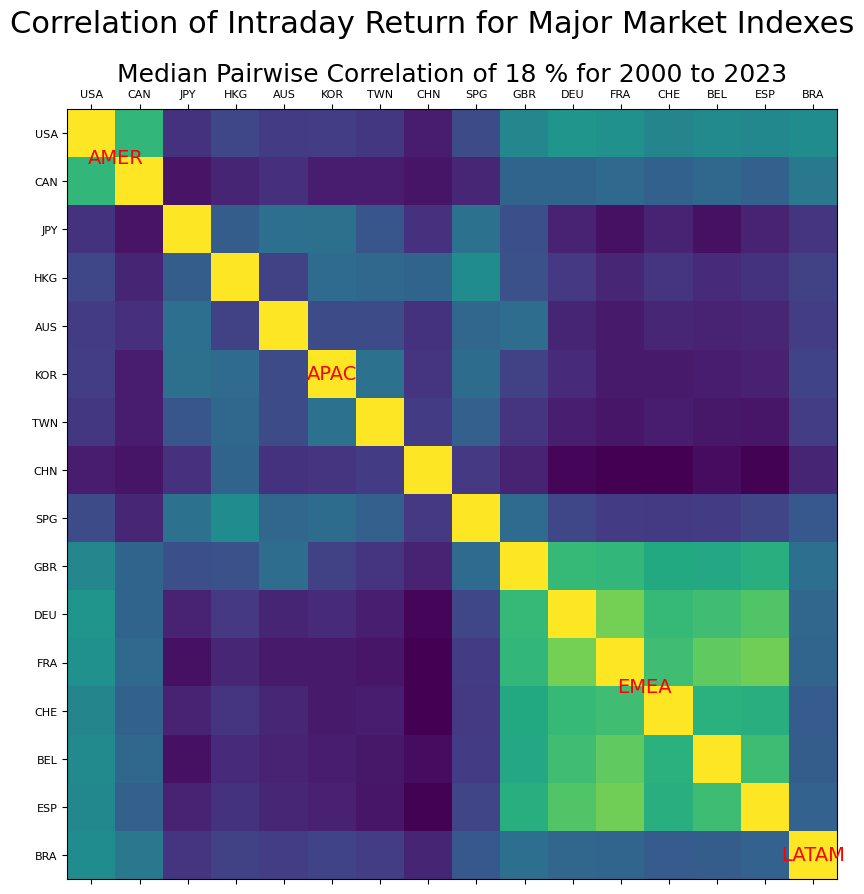

In [13]:
rf=pd.DataFrame({'Period':[],'Correlation':[]}).set_index("Period")

for feature in 'Daily Return','Overnight Return','Intraday Return':
    nprint(feature)
    rho=data.xs(feature,axis=1,level=1).corr()
    display(rho)
    np.median([1,2,3])

    figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
    plot.matshow(rho)
    plot.set_xticks(range(0,rho.shape[0]),universe.loc[rho.index,('Metadata','ISO3')],fontsize=8)
    plot.set_yticks(range(0,rho.shape[1]),universe.loc[rho.index,('Metadata','ISO3')],fontsize=8)

    for pos,label in [(0.5,'AMER'),(5,'APAC'),(11.5,'EMEA'),(15,'LATAM')]:
        plot.text(pos,pos,label,color='red',fontsize=14,horizontalalignment='center',verticalalignment='center')

    rf.loc[feature,"Correlation"]=np.median(np.array(rho)[np.triu_indices(rho.shape[0],k=1)])*hundred

    title="Correlation of %s for Major Market Indexes" % feature
    figure.suptitle(title,fontsize=22)
    plot.set_title("Median Pairwise Correlation of %.0f %% for %d to %d" % (rf.loc[feature,"Correlation"],fyear,lyear),fontsize=18)
    figure.savefig(title+".png",dpi=300,bbox_inches='tight')

rf['N*']=rho.shape[0]/(one+(rho.shape[0]-one)*rf['Correlation']/hundred)
rf['N-N*']=rho.shape[0]-rf['N*']
rf['N*/N']=rf['N*']/rho.shape[0]
display(rf)

In [32]:
# fit symmetric and asymmetric GARCH models using arch package GARCH process and extended GED distribution
feature='Daily Return'
style,fyear,lyear='GJR-GARCH-AR(1)',2000,2019
nprint("Fitting %s with %s with GED for %d-%d." % (feature,style,fyear,lyear))
from scipy.stats import chi2 as density
from tqdm.notebook import tqdm

for ticker in tqdm(universe.index):
    design=data[ticker].copy().dropna()

    if design[feature].count()>252:
        model=ARX(design.loc[(design.index.year>=fyear)&(design.index.year<=lyear),feature],lags=[1])
        model.volatility = GARCH2(1, 1, 1)
        model.distribution = GeneralizedError2()
        fit=model.fit(update_freq=0,disp='off',show_warning=False)

        if fit.optimization_result.success:
            universe.loc[ticker,(style,'sample')]=fit.nobs
            universe.loc[ticker,(style,'drift')]=fit.params[0]
            universe.loc[ticker,(style,'autocorrelation')]=fit.params[1]
            universe.loc[ticker,(style,'quiescent')]=fit.params[2]
            universe.loc[ticker,(style,'stimulus')]=fit.params[3]
            universe.loc[ticker,(style,'memory')]=fit.params[5]
            universe.loc[ticker,(style,'downside')]=fit.params[4]
            universe.loc[ticker,(style,'shape')]=one/fit.params[6]
            data[(ticker,'Volatility')]=fit.conditional_volatility
            data[(ticker,'Innovation')]=(data[(ticker,feature)]-fit.params[0]-fit.params[1]*data[(ticker,feature)].shift())/data[(ticker,'Volatility')]

        else:
            nprint("Regression failed for %s." % ticker)
            universe.loc[ticker,(style,'sample')]=fit.nobs

            for parameter in 'drift','autocorrelation','quiescent','stimulus','memory','downside','shape':
                universe.loc[ticker,(style,parameter)]=np.nan

    else:
        nprint("Insufficient observations for %s." % ticker)

        for parameter in 'sample','drift','autocorrelation','quiescent','stimulus','memory','downside','shape':
            universe.loc[ticker,(style,parameter)]=np.nan

xf=universe.xs(style,axis=1,level=0)
xf.index=universe[("Metadata","Country")]
xf.index.names=["Country"]
display(xf)
xf.style.to_latex()

14:23:51 Fitting Daily Return with GJR-GARCH-AR(1) with GED for 2000-2019.


  0%|          | 0/16 [00:00<?, ?it/s]

14:23:52 Regression failed for ^AXJO.


,sample,drift,autocorrelation,quiescent,stimulus,memory,downside,shape
Country,,,,,,,,
United States,5013.000000,0.049812,-0.055450,0.016969,-0.012516,0.891037,0.206881,0.722962
Canada,4803.000000,0.034768,0.024330,0.007520,0.019885,0.917880,0.098522,0.629690
Japan,3931.000000,0.039969,-0.026021,0.047942,0.033940,0.872283,0.132284,0.700031
Hong Kong,4241.000000,0.044251,-0.005904,0.017488,0.017344,0.933823,0.072108,0.704452
Australia,581.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Korea,4569.000000,0.051832,-0.007161,0.010833,0.031690,0.922658,0.077287,0.729582
Taiwan,3904.000000,0.044999,0.014665,0.011118,0.014869,0.939991,0.064249,0.759022
China,3626.000000,0.032605,-0.011619,0.021368,0.046889,0.938116,0.017366,0.756670
Singapore,3232.000000,0.021980,-0.012716,0.011756,0.053983,0.894266,0.078421,0.682596


'\\begin{tabular}{lrrrrrrrr}\n & sample & drift & autocorrelation & quiescent & stimulus & memory & downside & shape \\\\\nCountry &  &  &  &  &  &  &  &  \\\\\nUnited States & 5013.000000 & 0.049812 & -0.055450 & 0.016969 & -0.012516 & 0.891037 & 0.206881 & 0.722962 \\\\\nCanada & 4803.000000 & 0.034768 & 0.024330 & 0.007520 & 0.019885 & 0.917880 & 0.098522 & 0.629690 \\\\\nJapan & 3931.000000 & 0.039969 & -0.026021 & 0.047942 & 0.033940 & 0.872283 & 0.132284 & 0.700031 \\\\\nHong Kong & 4241.000000 & 0.044251 & -0.005904 & 0.017488 & 0.017344 & 0.933823 & 0.072108 & 0.704452 \\\\\nAustralia & 581.000000 & nan & nan & nan & nan & nan & nan & nan \\\\\nKorea & 4569.000000 & 0.051832 & -0.007161 & 0.010833 & 0.031690 & 0.922658 & 0.077287 & 0.729582 \\\\\nTaiwan & 3904.000000 & 0.044999 & 0.014665 & 0.011118 & 0.014869 & 0.939991 & 0.064249 & 0.759022 \\\\\nChina & 3626.000000 & 0.032605 & -0.011619 & 0.021368 & 0.046889 & 0.938116 & 0.017366 & 0.756670 \\\\\nSingapore & 3232.000000 & 0

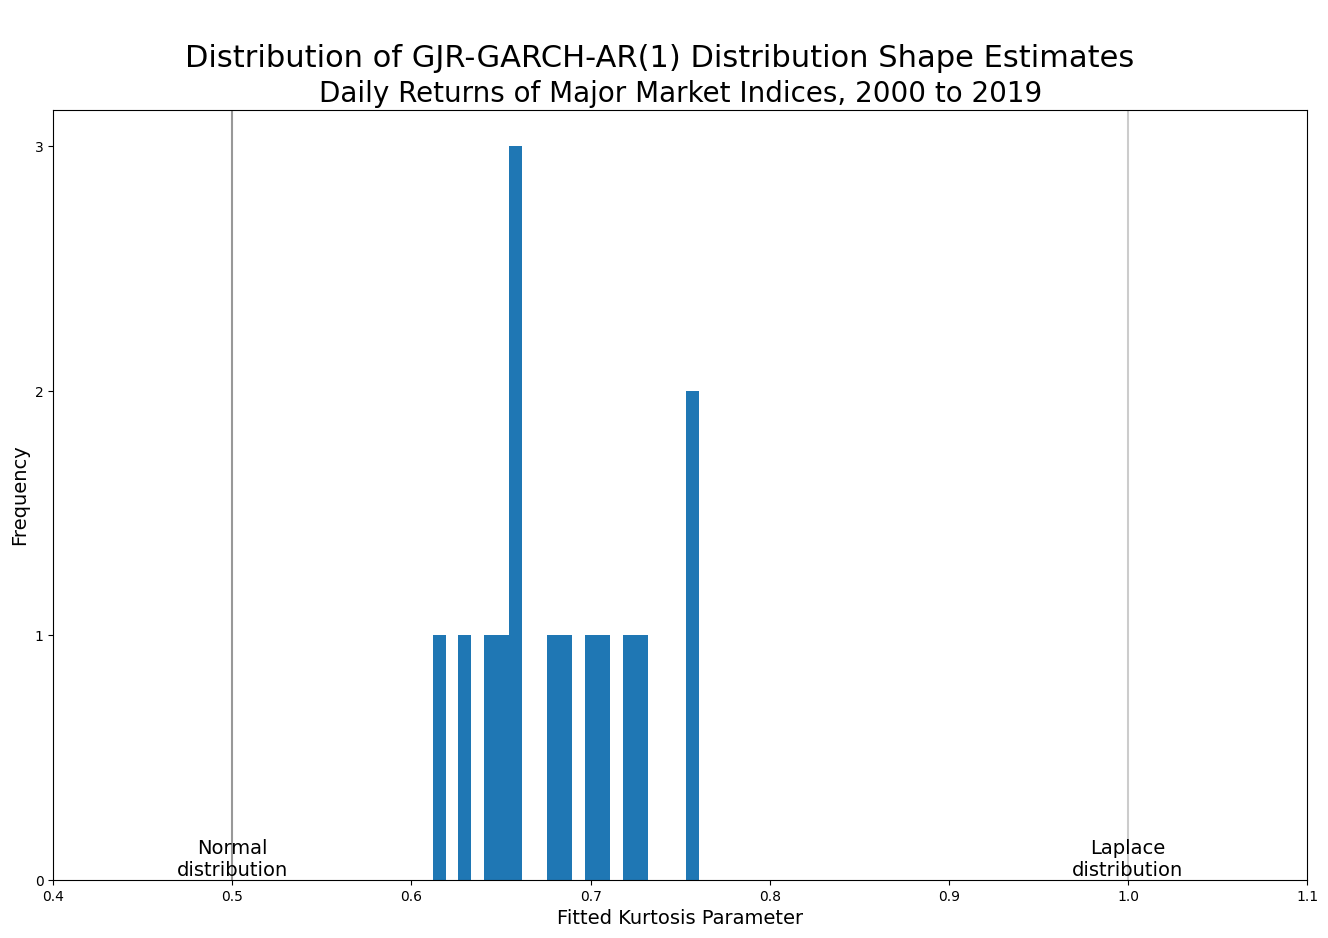

In [52]:
from matplotlib.ticker import FormatStrFormatter

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
lower,upper=0.4,1.1
samples,bins,patches=plot.hist(universe.xs(style,axis=1,level=0)['shape'],bins=np.linspace(lower,upper,100))
plot.set_xlim(lower,upper)
plot.axvline(half,color="black",alpha=0.25)
plot.set_xlabel("Fitted Kurtosis Parameter",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
title="Distribution of %s Distribution Shape Estimates" % style
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("%ss of Major Market Indices, %d to %d" % (feature,fyear,lyear),fontsize=20)
plot.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plot.yaxis.set_ticks(np.arange(*plot.get_ylim(),one))

for x,t in (half,"Normal\ndistribution"),(one,"Laplace\ndistribution"):
    plot.axvline(x,color='black',alpha=0.2)
    plot.text(x,zero,t,fontsize=14,ha='center',va='bottom')

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

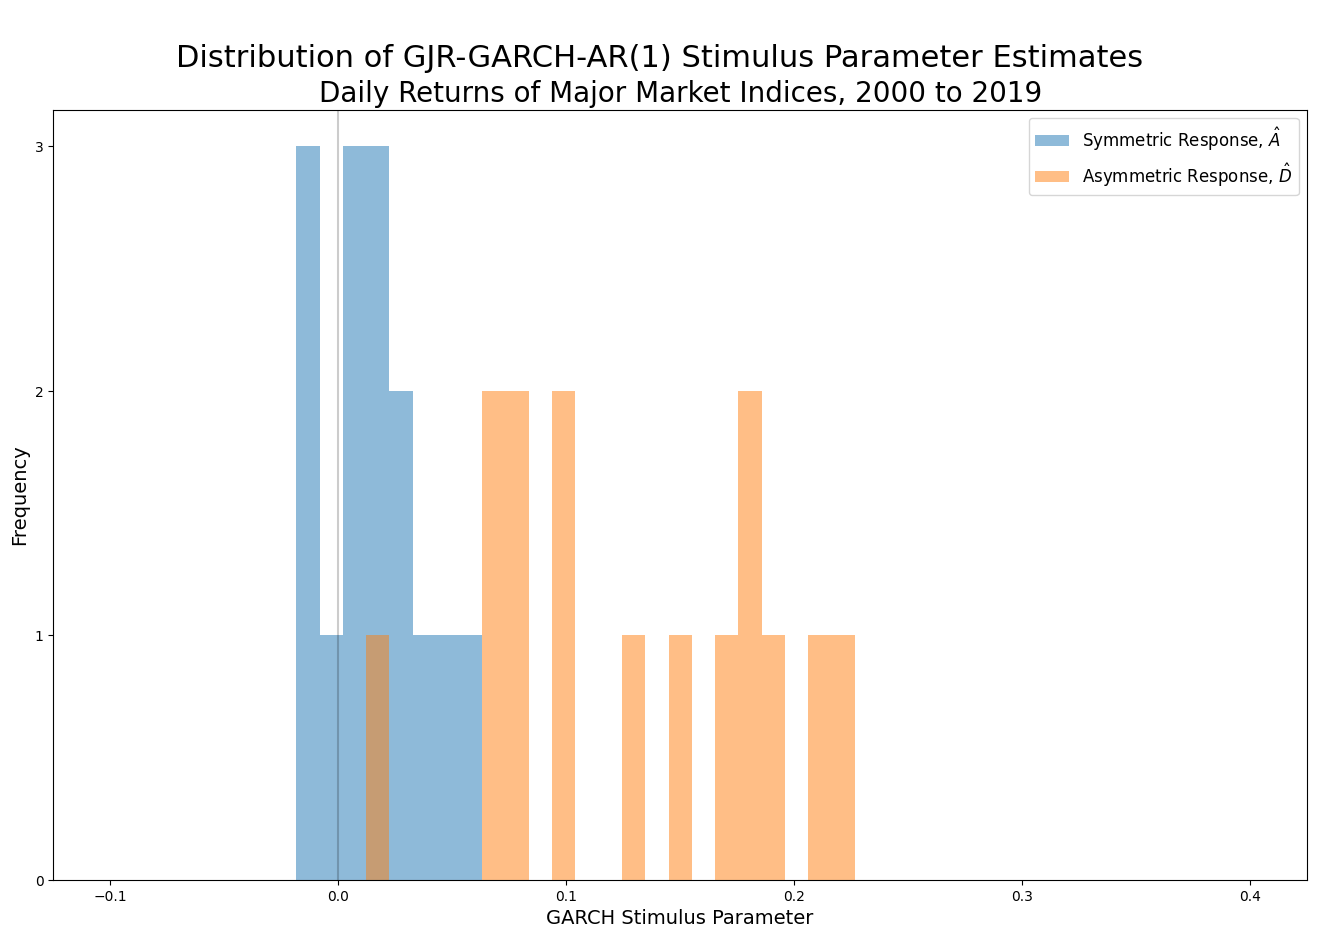

In [55]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
samples,bins,patches=plot.hist(universe.xs(style,axis=1,level=0)['stimulus'],bins=np.linspace(-0.1,0.4,50),alpha=0.5,label='Symmetric Response, $\\hat{A}$')
plot.hist(universe.xs(style,axis=1,level=0)['downside'],bins=bins,alpha=0.5,label='Asymmetric Response, $\\hat{D}$')
plot.set_xlabel("GARCH Stimulus Parameter",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
plot.legend(fontsize=12)
title="Distribution of %s Stimulus Parameter Estimates" % style
figure.suptitle("\n"+title,fontsize=22)
plot.set_title("%ss of Major Market Indices, %d to %d" % (feature,fyear,lyear),fontsize=20)
plot.axvline(color='black',alpha=0.2)
plot.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plot.yaxis.set_ticks(np.arange(*plot.get_ylim(),one))
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [60]:
from scipy.stats import ttest_1samp as ttest,t as density
results=pd.DataFrame({("Variable",""):[],("Tested","Mean"):[],("Sample","Mean"):[],("Sample","St.Dev."):[],("Nominal","t Statistic"):[],("Nominal","p Value"):[]}).set_index("Variable")
results.columns=pd.MultiIndex.from_tuples(results.columns)
study_group=universe[universe[(style,"drift")].notna()].index #['^GSPC','^N225','399001.SZ','^FTSE','^BVSP']
display(rho.loc[study_group,study_group])
N=len(study_group)
rf['N*']=N/(one+(N-one)*rf['Correlation']/hundred)
rf['N-N*']=N-rf['N*']
rf['N*/N']=rf['N*']/N
display(rf) # recomputed for the size of the study group

for variable in 'stimulus','downside','shape':
    sample=universe[universe.index.isin(study_group)].xs(style,axis=1,level=0)[variable]
    vname="Symmetric Response" if variable=='stimulus' else "Asymmetric Response" if variable=='downside' else 'Distribution Shape'
    results.loc[vname,("Tested","Mean")]=half if variable=='shape' else zero
    results.loc[vname,("Sample","Mean")]=sample.mean()
    results.loc[vname,("Sample","St.Dev.")]=sample.std()
    test_results=ttest(sample,results.loc[vname,("Tested","Mean")])
    results.loc[vname,("Nominal","t Statistic")]=test_results.statistic
    results.loc[vname,("Nominal","p Value")]=test_results.pvalue

results[("Nominal","Significance")]=results[("Nominal","p Value")].apply(lambda x:'***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
results[("Adjusted","t* Statistic")]=results[("Nominal","t Statistic")]*np.sqrt(rf.loc[feature,"N*/N"])
results[("Adjusted","p* Value")]=one-density(rf.loc[feature,"N*"]-one).cdf(results[("Adjusted","t* Statistic")])
results[("Nominal","Significance*")]=results[("Adjusted","p* Value")].apply(lambda x:'***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
print("t Test for Canonical Mean in Parameter Estimates (n.b. p Values likely biased downwards due to cross-correlation of time-series)")
display(results)
results.style.to_latex()

Country,^GSPC,^GSPTSE,^N225,^HSI,^KS11,^TWII,399001.SZ,^STI,^FTSE,^GDAXI,^FCHI,^SSMI,^BFX,^IBEX,^BVSP
Country,,,,,,,,,,,,,,,
^GSPC,1.000000,0.649742,0.119667,0.188332,0.155483,0.133561,0.046703,0.203115,0.444292,0.505203,0.490582,0.439412,0.455776,0.450591,0.470373
^GSPTSE,0.649742,1.000000,0.022192,0.076067,0.047166,0.050244,0.024547,0.077195,0.300519,0.301804,0.320848,0.288319,0.318305,0.284122,0.379173
^N225,0.119667,0.022192,1.000000,0.272167,0.349026,0.242627,0.114126,0.357719,0.220551,0.067650,0.015999,0.070424,0.015116,0.065481,0.124637
^HSI,0.188332,0.076067,0.272167,1.000000,0.328121,0.311270,0.302239,0.468547,0.224308,0.139618,0.078066,0.127408,0.089015,0.118291,0.168127
^KS11,0.155483,0.047166,0.349026,0.328121,1.000000,0.357169,0.127116,0.331936,0.168339,0.091523,0.040662,0.042623,0.044943,0.063666,0.177227
^TWII,0.133561,0.050244,0.242627,0.311270,0.357169,1.000000,0.152506,0.284458,0.123065,0.052683,0.030087,0.049412,0.033033,0.029818,0.156810
399001.SZ,0.046703,0.024547,0.114126,0.302239,0.127116,0.152506,1.000000,0.140556,0.065186,-0.018649,-0.032124,-0.030493,0.003717,-0.024245,0.076532
^STI,0.203115,0.077195,0.357719,0.468547,0.331936,0.284458,0.140556,1.000000,0.329220,0.189583,0.147928,0.143626,0.146459,0.182381,0.251108
^FTSE,0.444292,0.300519,0.220551,0.224308,0.168339,0.123065,0.065186,0.329220,1.000000,0.658539,0.650972,0.593243,0.591189,0.613793,0.345527


,Correlation,N*,N-N*,N*/N
Period,,,,
Daily Return,33.038033,2.666513,12.333487,0.177768
Overnight Return,29.184209,2.949395,12.050605,0.196626
Intraday Return,17.980403,4.264688,10.735312,0.284313


t Test for Canonical Mean in Parameter Estimates (n.b. p Values likely biased downwards due to cross-correlation of time-series)


Tested   Sample              Nominal           \
                        Mean     Mean  St.Dev. t Statistic  p Value   
Variable                                                              
Symmetric Response  0.000000 0.015140 0.020719    2.830036 0.013366   
Asymmetric Response 0.000000 0.129118 0.060843    8.219091 0.000001   
Distribution Shape  0.500000 0.684304 0.044086   16.191347 0.000000   

                                     Adjusted                Nominal  
                    Significance t* Statistic p* Value Significance*  
Variable                                                              
Symmetric Response             *     1.193213 0.187635                
Asymmetric Response          ***     3.465373 0.047723             *  
Distribution Shape           ***     6.826674 0.016337             *

'\\begin{tabular}{lrrrrrlrrl}\n & Tested & \\multicolumn{2}{r}{Sample} & \\multicolumn{3}{r}{Nominal} & \\multicolumn{2}{r}{Adjusted} & Nominal \\\\\n & Mean & Mean & St.Dev. & t Statistic & p Value & Significance & t* Statistic & p* Value & Significance* \\\\\nVariable &  &  &  &  &  &  &  &  &  \\\\\nSymmetric Response & 0.000000 & 0.015140 & 0.020719 & 2.830036 & 0.013366 & * & 1.193213 & 0.187635 &  \\\\\nAsymmetric Response & 0.000000 & 0.129118 & 0.060843 & 8.219091 & 0.000001 & *** & 3.465373 & 0.047723 & * \\\\\nDistribution Shape & 0.500000 & 0.684304 & 0.044086 & 16.191347 & 0.000000 & *** & 6.826674 & 0.016337 & * \\\\\n\\end{tabular}\n'